In [1]:
!/opt/bin/nvidia-smi

Wed Mar 16 01:36:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/project')
print(os.getcwd())

In [44]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from keras.layers import Dense, Dropout, LSTM,Reshape, GRU,Conv1D, Conv2D,Flatten,Permute, multiply,BatchNormalization, Activation, AveragePooling1D, GlobalAveragePooling1D, Lambda, Input, Concatenate, Add, UpSampling1D, Multiply, ReLU, Reshape
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau,LearningRateScheduler
from keras.initializers import random_normal
from keras.optimizers import rmsprop_v2, adam_v2
from keras import regularizers
from keras.callbacks import Callback

In [94]:
import matplotlib.pyplot as plt

def plot_func(y_list, x_list, label_list, title):
  plt.figure()
  for i in range(len(x_list)):
    x = x_list[i]
    y = y_list[i]
    label = label_list[i]
    plt.plot(x, y, label=label)
  plt.title(title)
  plt.legend()
  plt.savefig('pics/'+title+'.png')
  plt.show()
  return


# ['loss', 'mse', 'val_loss', 'val_mse', 'lr']

def plot_all(hist, name):
  info_hist = hist.history
  y = np.array(hist.epoch) + 1
  plot_func([info_hist['loss']], [y], ['Train loss'], f'Train Loss Curve of {name}')
  plot_func([info_hist['val_loss']], [y], ['Val loss'], f'Val Loss Curve of {name}')
  plot_func([info_hist['loss'], info_hist['val_loss']], [y, y], ['Train loss', 'Val loss'], f'Loss Curve of {name}')
  plot_func([info_hist['mse']], [y], ['Train mse'], f'Train MSE Curve of {name}')
  plot_func([info_hist['val_mse']], [y], ['Val mse'], f'Val MSE Curve of {name}')
  plot_func([info_hist['mse'], info_hist['val_mse']], [y, y], ['Train mse', 'Val mse'], f'MSE Curve of {name}')
  plot_func([info_hist['lr']], [y], ['Learning rate'], f'Learning Rate Curve of {name}')

In [5]:
def plot_result(y_true,y_pre,model_name='LSTM'):
    x = range(len(y_true))
    
    plt.figure(dpi=200)
    plt.title(f'{model_name} Result Plot',fontsize=20)
    plt.xlabel(u'timestep',fontsize=14)
    plt.ylabel(u'y',fontsize=14)

    
    plt.plot(x,y_true,color="g",linewidth=1,label='label')
    plt.plot(x,y_pre,color="r",linewidth=1,label='predict')

    plt.legend(loc=2)
    plt.show()


In [6]:
config={
    'csv_path' : './2018Floor2.csv', #file to run
    'col' : ['z1_Light(kW)', 'z1_S1(degC)'], #column to predict
    'train_rate' : 0.7,     #training
    'valid_rate' : 0.2,     #valid，the rest is for testing
    'seq_len' : 16,         #sequence length｜size of sliding window
    'epoch' : 50,           
    'batch' : 128,
    'lr' : 0.0001,
}


In [ ]:
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         temp_df = pd.read_csv(os.path.join(dirname, filename))
#         df = pd.concat([df,temp_df],axis=0).reset_index(drop=True)
#         print(os.path.join(dirname, filename))

In [9]:
def gen_data(df,config):
    col = config['col']
    window = config['seq_len']
    
    data = df[col].dropna().values
    print(data.shape)
    data_list = [data[:, 0], data[:, 1]]
    Xs = []
    ys = []
    for data in data_list:
      data = (data-np.min(data)) / (np.max(data)-np.min(data))
      
      X = np.zeros((len(data)-window,window,1))
      y = np.zeros((len(data)-window,window,1))
      
      for i in range(len(data)-window-1):
          X[i,:,0] = data[i:i+window]
          y[i,:,0] = data[i+1:i+window+1]
      Xs.append(X)
      ys.append(y)
        
    return Xs,ys


In [10]:
sample_df = pd.read_csv(config['csv_path'])
Xs,ys = gen_data(sample_df,config)

(101925, 2)


In [11]:
def nan_plot(df):
    plt.figure(dpi=200)
    x = list(df.columns)
    y = []
    for col in x:
        y.append((len(df) - df[col].count())/len(df))
    y_pos = [i for i in range(1,len(x)+1)]

    plt.bar(y_pos, y, align='center', alpha=0.7)
    plt.xticks(y_pos, x,rotation=90,fontsize=6)
    plt.xlabel('Columns')
    plt.ylabel('NAN Rate')
    plt.title('CU-BEMS Dataset')
    plt.savefig('./cu_nanrate.jpg',bbox_inches='tight')


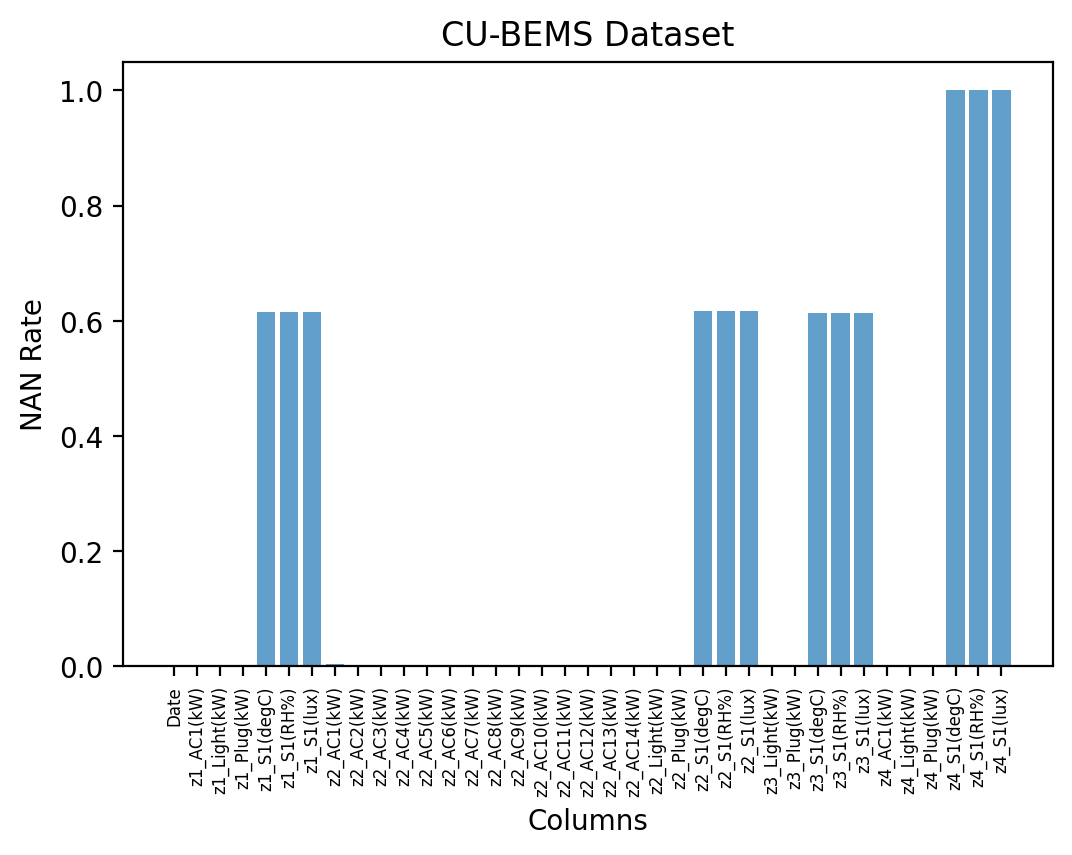

In [12]:
nan_plot(sample_df)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


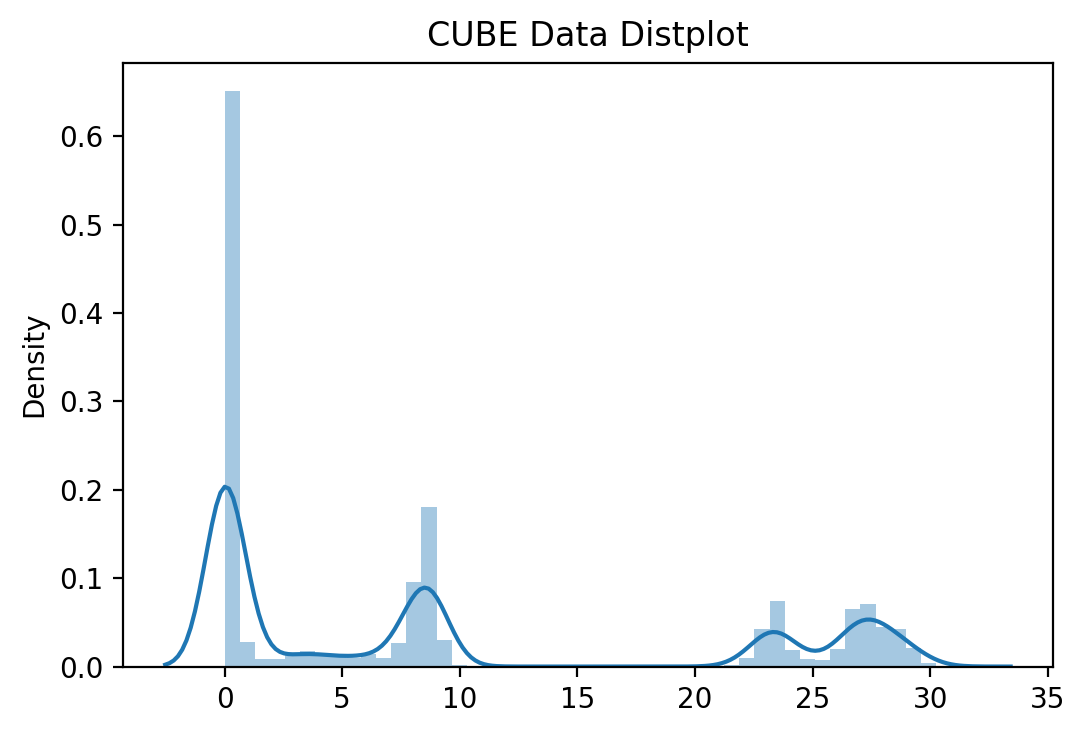

In [13]:
plt.figure(dpi=200)
sns.distplot(sample_df[config['col']])
plt.title('CUBE Data Distplot')
plt.savefig('./cube_dist.jpg')



In [ ]:
# for dirname, null_counts=enames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         temp_df = pd.read_csv(os.path.join(dirname, filename))
#         sample_df = pd.concat([df,temp_df],axis=0).reset_index(drop=True)
#         X,y = gen_data(sample_df,config)
#         print(os.path.join(dirname, filename))


In [19]:
train_num = int(len(Xs[0])*config['train_rate'])
valid_num = int(len(Xs[0])*config['valid_rate'])
X_trains = [Xs[0][:train_num], Xs[1][:train_num]]
y_train = ys[0][:train_num]
X_valids = [Xs[0][train_num:train_num+valid_num], Xs[1][train_num:train_num+valid_num]]
y_valid = ys[0][train_num:train_num+valid_num]
X_tests = [Xs[0][train_num+valid_num:], Xs[1][train_num+valid_num:]]
y_test = ys[0][train_num+valid_num:]

In [15]:
def lstm_model(seq_len):
    
    seq_input_1 =  Input((seq_len,1), name='seq_input_1')
    seq_input_2 =  Input((seq_len,1), name='seq_input_2')

    x1 = LSTM(units=16,return_sequences=True)(seq_input_1)
    x1 = LSTM(units=16,return_sequences=False)(x1)

    x1 = Dense(32,activation='tanh')(x1)
    x1 = BatchNormalization()(x1)

    x2 = LSTM(units=16,return_sequences=True)(seq_input_2)
    x2 = LSTM(units=16,return_sequences=False)(x2)

    x2 = Dense(32,activation='tanh')(x2)
    x2 = BatchNormalization()(x2)
    

    x = Concatenate()([x1, x2])

    out = Dense(1)(x)
    
    model = Model(inputs=[seq_input_1, seq_input_2], outputs=out)
    
    return model


In [21]:
def Residual_block(x,filters,kernel_size,n):
    dilation_rates = [2**i for i in range(n)]
    res_x = x
    skip_x = []
    for dilation_rate in dilation_rates:
        x = BatchNormalization()(x)
        x = Conv1D(filters=filters,
            kernel_size=kernel_size, 
            padding='causal',
            activation='tanh',
            dilation_rate=dilation_rate)(x)
        x = Conv1D(filters=1,
            kernel_size=1,
            padding='same'
            )(x)
        skip_x.append(x)
        res_x = Add()([res_x,x])
    ter_x = skip_x[0]
    for i in range(1, len(skip_x)):
        ter_x = Add()([ter_x, skip_x[i]])
    return ter_x


In [69]:
def singleSeriesNet(seq_len): 
    seq_input =  Input((seq_len,1))
    #Lstm part
    x = LSTM(units=16,return_sequences=True)(seq_input)
    x = LSTM(units=16,return_sequences=True)(x)
    x = Dense(1,activation='tanh')(x)
    # x = BatchNormalization()(x)
    #Residual part
    x1 = Conv1D(filters=4,
          kernel_size=6, 
          padding='causal')(seq_input)
    x1 = Residual_block(x1,4,3,3)
    x1 = Residual_block(x1,8,3,2)
    x1 = Conv1D(filters=1,
          kernel_size=1, 
          padding='same')(x1)
    x = Multiply()([x,x1])
    out = ReLU()(x)
    model = Model(inputs=seq_input, outputs=out)
    return model

In [22]:
def SeriesNet(x_ori): 
    #Lstm part
    x = LSTM(units=16,return_sequences=True)(x_ori)
    x = LSTM(units=16,return_sequences=True)(x)
    x = Dense(1,activation='tanh')(x)
    # x = BatchNormalization()(x)
    #Residual part
    x1 = Conv1D(filters=4,
          kernel_size=6, 
          padding='causal')(x_ori)
    x1 = Residual_block(x1,4,3,3)
    x1 = Residual_block(x1,8,3,2)
    x1 = Conv1D(filters=1,
          kernel_size=1, 
          padding='same')(x1)
    x = Multiply()([x,x1])
    out = ReLU()(x)
    return out



In [48]:
def DoubleSeriesNet_3(seq_len):
  seq_input_1 =  Input((seq_len,1), name='seq_input_1')
  seq_input_2 =  Input((seq_len,1), name='seq_input_2')

  sx1 = SeriesNet(seq_input_1)
  sx2 = SeriesNet(seq_input_2)

  x = Concatenate(axis=1)([sx1, sx2])
  x = Reshape([seq_len*2,])(x)
  out = Dense(seq_len,activation='relu')(x)
  out = Reshape([seq_len, 1])(out)
  model = Model(inputs=[seq_input_1, seq_input_2], outputs=out)
  return model


In [67]:
def DoubleSeriesNet_2(seq_len, ssn_1, ssn_2):
  sx1 = ssn_1.output
  sx2 = ssn_2.output
  x = Concatenate()([sx1, sx2])
  x = Reshape([seq_len*2,])(x)
  out = Dense(seq_len,activation='relu')(x)
  out = Reshape([seq_len, 1])(out)
  model = Model(inputs=[ssn_1.input, ssn_2.input], outputs=out)
  return model

In [16]:
model1 = lstm_model(seq_len=config['seq_len'])

In [49]:
model2 = DoubleSeriesNet_3(seq_len=config['seq_len'])

In [ ]:
model1.summary()

In [ ]:
model2.summary()


In [ ]:
plateau = ReduceLROnPlateau(monitor="val_loss", verbose=1, mode='min', factor=0.3, patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
opt = adam_v2.Adam(lr=config['lr'])
model1.compile(
              loss='mse',
              optimizer=opt,
             metrics=['mse'])

# train the model
print("[INFO] training model...")
model1.fit(
    X_trains, y_train,
    validation_data=(X_valids,y_valid[:,config['seq_len']-1,:]),
    callbacks=[early_stopping,plateau],shuffle=True,
    epochs=config['epoch'], batch_size=config['batch'])


In [ ]:
y_pre = model1.predict(X_tests)
plot_result(y_true=y_test[:,config['seq_len']-1,:],y_pre=y_pre,model_name='LSTM')

In [62]:
model_3_1 = singleSeriesNet(seq_len=config['seq_len'])

In [70]:
model_3_2 = singleSeriesNet(seq_len=config['seq_len'])

In [ ]:
plateau = ReduceLROnPlateau(monitor="val_loss", verbose=1, mode='min', factor=0.3, patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
opt = adam_v2.Adam(lr=config['lr'])
model_3_1.compile(
              loss='mse',
              optimizer=opt,
             metrics=['mse'])

# train the model
print("[INFO] training model...")
hist_model_3_1 = model_3_1.fit(
    X_trains[0], y_train,
    validation_data=(X_valids[0],y_valid),
    callbacks=[early_stopping,plateau],shuffle=True,
    epochs=config['epoch'], batch_size=config['batch'])

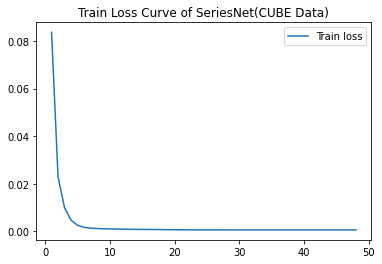

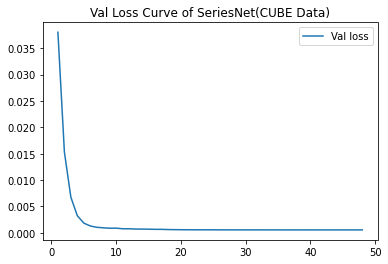

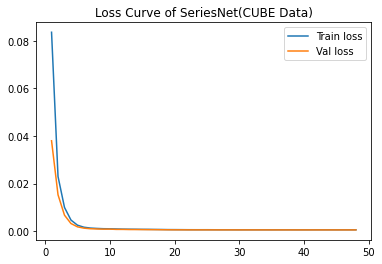

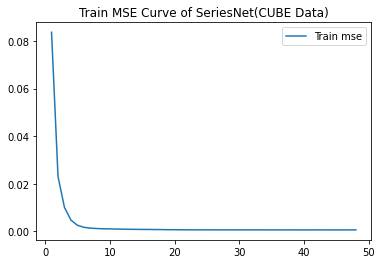

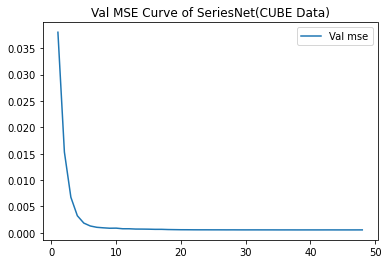

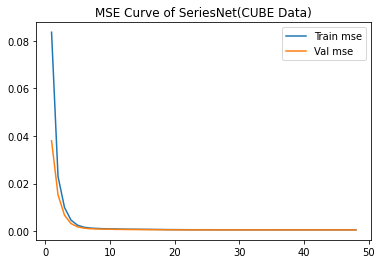

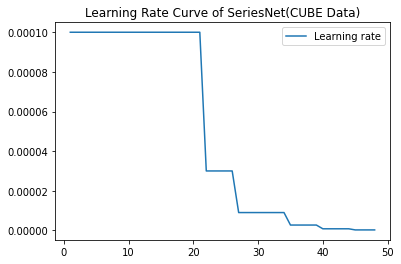

In [95]:
plot_all(hist_model_3_1, 'SeriesNet(CUBE Data)')

In [83]:
model_3 = DoubleSeriesNet_3(config['seq_len'])

In [84]:
plateau = ReduceLROnPlateau(monitor="val_loss", verbose=1, mode='min', factor=0.3, patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
opt = adam_v2.Adam(lr=0.001)
model_3.compile(
              loss='mse',
              optimizer=opt,
             metrics=['mse'])

# train the model
print("[INFO] training model...")
hist_model_3 = model_3.fit(
    X_trains, y_train,
    validation_data=(X_valids,y_valid),
    callbacks=[early_stopping,plateau],shuffle=True,
    epochs=100, batch_size=config['batch'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[INFO] training model...
Epoch 1/100
558/558 [==============================] - 31s 34ms/step - loss: 0.0256 - mse: 0.0256 - val_loss: 0.0031 - val_mse: 0.0031 - lr: 0.0010
Epoch 2/100
558/558 [==============================] - 17s 31ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 8.9727e-04 - val_mse: 8.9727e-04 - lr: 0.0010
Epoch 3/100
558/558 [==============================] - 17s 31ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 6.4798e-04 - val_mse: 6.4798e-04 - lr: 0.0010
Epoch 4/100
558/558 [==============================] - 17s 31ms/step - loss: 9.0704e-04 - mse: 9.0704e-04 - val_loss: 5.7600e-04 - val_mse: 5.7600e-04 - lr: 0.0010
Epoch 5/100
558/558 [==============================] - 17s 31ms/step - loss: 7.4276e-04 - mse: 7.4276e-04 - val_loss: 5.2946e-04 - val_mse: 5.2946e-04 - lr: 0.0010
Epoch 6/100
558/558 [==============================] - 17s 31ms/step - loss: 6.3626e-04 - mse: 6.3626e-04 - val_loss: 7.0579e-04 - val_mse: 7.0579e-04 - lr: 0.0010
Epoch 7/100
558/558 [==

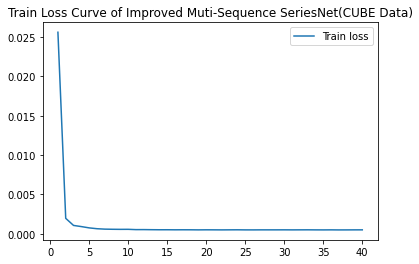

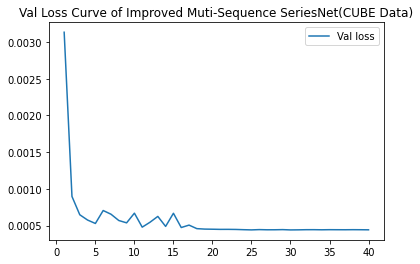

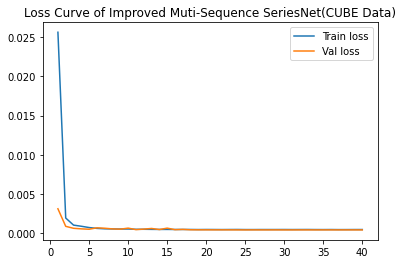

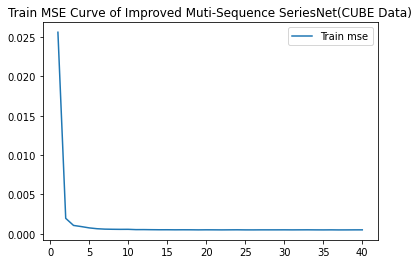

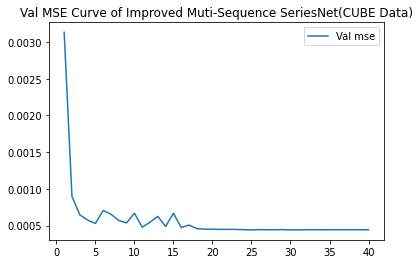

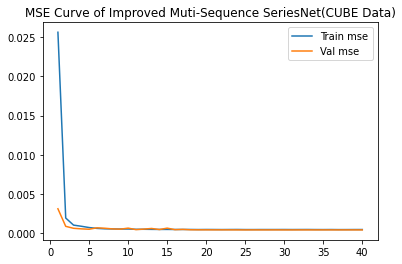

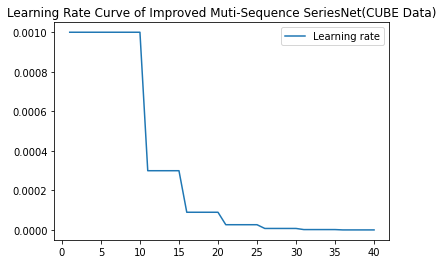

In [96]:
plot_all(hist_model_3, 'Improved Muti-Sequence SeriesNet(CUBE Data)')

In [74]:
y_pre_3_1 = model_3_1.predict(X_tests[0])
res_dict_3_1 = evaluate(y_test[:,config['seq_len']-1,:],y_pre_3_1[:,config['seq_len']-1,:])

{'r2': 0.9955583011943535, 'mae': 0.0071065787180690804, 'rmse': 0.024517179814576663}


In [85]:
y_pre_3 = model_3.predict(X_tests)
res_dict_3 = evaluate(y_test[:,config['seq_len']-1,:],y_pre_3[:,config['seq_len']-1,:])

{'r2': 0.996731201415198, 'mae': 0.00606127947583632, 'rmse': 0.02103245847739342}


In [72]:
model_3 = DoubleSeriesNet_2(config['seq_len'], model_3_1, model_3_2)

In [76]:
for i, layer in enumerate(model_3.layers): # printing names of layers
   print(i, layer.name)

for layer in model_3.layers[:52]:
   layer.trainable = False
for layer in model_3.layers[52:]:
   layer.trainable = True

0 seq_input
1 input_1
2 conv1d_216
3 conv1d_240
4 batch_normalization_92
5 batch_normalization_102
6 conv1d_217
7 conv1d_241
8 conv1d_218
9 conv1d_242
10 batch_normalization_93
11 batch_normalization_103
12 conv1d_219
13 conv1d_243
14 conv1d_220
15 conv1d_244
16 batch_normalization_94
17 batch_normalization_104
18 conv1d_221
19 conv1d_245
20 add_147
21 conv1d_222
22 add_163
23 conv1d_246
24 add_148
25 add_164
26 batch_normalization_95
27 batch_normalization_105
28 conv1d_223
29 conv1d_247
30 conv1d_224
31 conv1d_248
32 batch_normalization_96
33 batch_normalization_106
34 conv1d_225
35 conv1d_249
36 lstm_40
37 conv1d_226
38 lstm_44
39 conv1d_250
40 lstm_41
41 add_151
42 lstm_45
43 add_167
44 dense_26
45 conv1d_227
46 dense_29
47 conv1d_251
48 multiply_18
49 multiply_20
50 re_lu_18
51 re_lu_20
52 concatenate_11
53 reshape_6
54 dense_30
55 reshape_7


In [ ]:
plateau = ReduceLROnPlateau(monitor="val_loss", verbose=1, mode='min', factor=0.3, patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
opt = adam_v2.Adam(lr=config['lr'])
model_3.compile(
              loss='mse',
              optimizer=opt,
             metrics=['mse'])

# train the model
print("[INFO] training model...")
model_3.fit(
    X_trains, y_train,
    callbacks=[early_stopping,plateau],shuffle=True,
    epochs=100, batch_size=config['batch'])

In [ ]:
plateau = ReduceLROnPlateau(monitor="val_loss", verbose=1, mode='min', factor=0.3, patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
opt = adam_v2.Adam(lr=config['lr'])
model2.compile(
              loss='mse',
              optimizer=opt,
             metrics=['mse'])

# train the model
print("[INFO] training model...")
model2.fit(
    X_trains, y_train,
    validation_data=(X_trains,y_train),
    callbacks=[early_stopping,plateau],shuffle=True,
    epochs=config['epoch'], batch_size=config['batch'])



In [57]:
plateau = ReduceLROnPlateau(monitor="val_loss", verbose=1, mode='min', factor=0.3, patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
opt = adam_v2.Adam(lr=9.0000e-06)
model2.compile(
              loss='mse',
              optimizer=opt,
             metrics=['mse'])

# train the model
print("[INFO] training model...")
model2.fit(
    X_trains, y_train,
    validation_data=(X_trains,y_train),
    callbacks=[early_stopping,plateau],shuffle=True,
    epochs=100, batch_size=config['batch'])

[INFO] training model...
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


558/558 [==============================] - 40s 51ms/step - loss: 6.5467e-04 - mse: 6.5467e-04 - val_loss: 6.2957e-04 - val_mse: 6.2957e-04 - lr: 9.0000e-06
Epoch 2/100
558/558 [==============================] - 26s 47ms/step - loss: 6.4948e-04 - mse: 6.4948e-04 - val_loss: 6.2743e-04 - val_mse: 6.2743e-04 - lr: 9.0000e-06
Epoch 3/100
558/558 [==============================] - 26s 47ms/step - loss: 6.4951e-04 - mse: 6.4951e-04 - val_loss: 6.2712e-04 - val_mse: 6.2712e-04 - lr: 9.0000e-06
Epoch 4/100
558/558 [==============================] - 26s 47ms/step - loss: 6.4929e-04 - mse: 6.4929e-04 - val_loss: 6.2742e-04 - val_mse: 6.2742e-04 - lr: 9.0000e-06
Epoch 5/100
558/558 [==============================] - 26s 47ms/step - loss: 6.5006e-04 - mse: 6.5006e-04 - val_loss: 6.2495e-04 - val_mse: 6.2495e-04 - lr: 9.0000e-06
Epoch 6/100
558/558 [==============================] - ETA: 0s - loss: 6.4730e-04 - mse: 6.4730e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 2.7000000955013093e

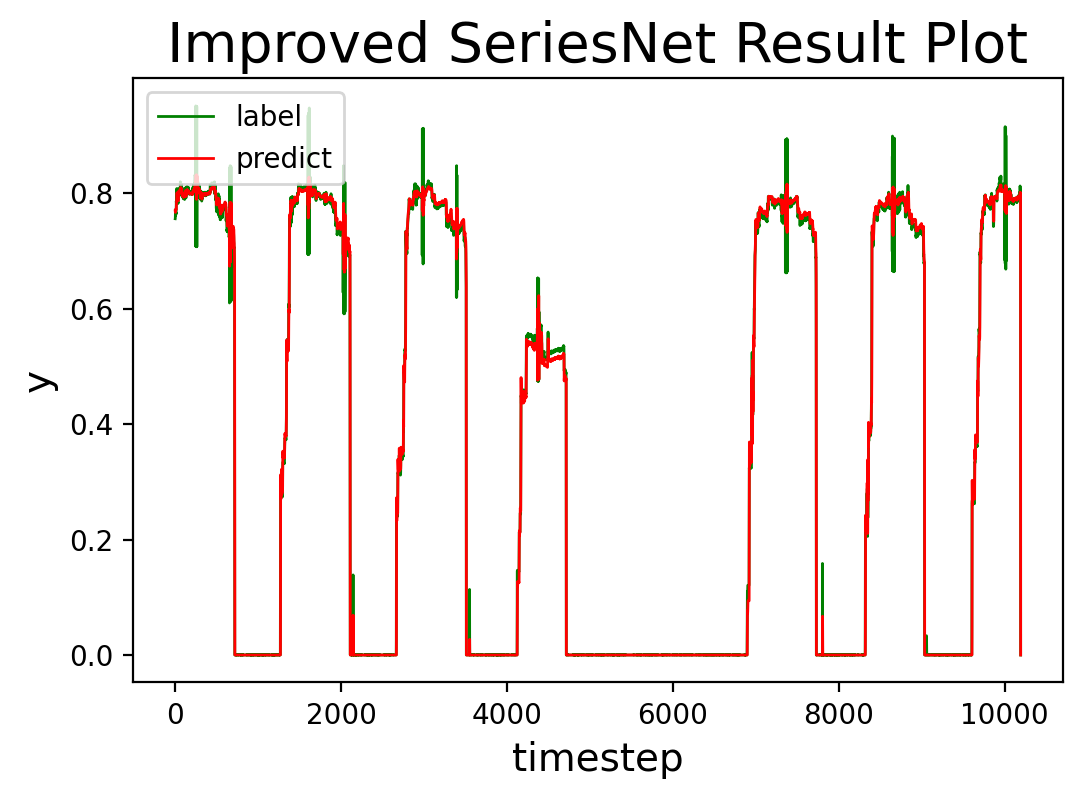

In [97]:
y_pre2 = model_3.predict(X_tests)
plot_result(y_true=y_test[:,config['seq_len']-1,:],y_pre=y_pre2[:,config['seq_len']-1,:],model_name='Improved SeriesNet')

In [53]:
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
def evaluate(y_true,y_pre):
    
    res_dict = dict()
    r2 = r2_score(y_true,y_pre)
    mae = mean_absolute_error(y_true,y_pre)
    rmse = np.sqrt(mean_squared_error(y_true,y_pre))
    res_dict['r2'] = r2
    res_dict['mae'] = mae
    res_dict['rmse'] = rmse
    print(res_dict)
    return res_dict



In [98]:
res_dict = evaluate(y_test[:,config['seq_len']-1,:],y_pre)
res_dict2 = evaluate(y_test[:,config['seq_len']-1,:],y_pre2[:,config['seq_len']-1,:])


{'r2': 0.9870169463205906, 'mae': 0.009915394824404981, 'rmse': 0.04191643955558682}
{'r2': 0.996731201415198, 'mae': 0.00606127947583632, 'rmse': 0.02103245847739342}


In [55]:
print('LSTM')
res_dict

LSTM


{'mae': 0.009915394824404981,
 'r2': 0.9870169463205906,
 'rmse': 0.04191643955558682}

In [99]:
print('Improved SeriesNet')
res_dict2


Improved SeriesNet


{'mae': 0.00606127947583632,
 'r2': 0.996731201415198,
 'rmse': 0.02103245847739342}